In [1]:
%reset -f
%matplotlib inline
import numpy as np
import lib.io.stan
import lib.plots.stan
import lib.utils.stan
import subprocess
import matplotlib.pyplot as plt
import os 
from matplotlib.lines import Line2D
import importlib

In [2]:
data_dir = f'datasets/id002_cj'
results_dir = f'results/exp10/exp10.50.3'
os.makedirs(results_dir,exist_ok=True)
os.makedirs(f'{results_dir}/logs',exist_ok=True)
os.makedirs(f'{results_dir}/figures',exist_ok=True)

network = np.load(f'{data_dir}/CJ_network.npz')
SC = network['SC']
K = np.max(SC)
SC = SC / K
SC[np.diag_indices(SC.shape[0])] = 0
gain_mat = network['gain_mat']

slp = np.load(f'{data_dir}/CJ_fit_trgt.npz')['fit_trgt']
slp_ds = slp[0:-1:10,:]
snsr_pwr = np.sum(slp_ds**2, axis=0)

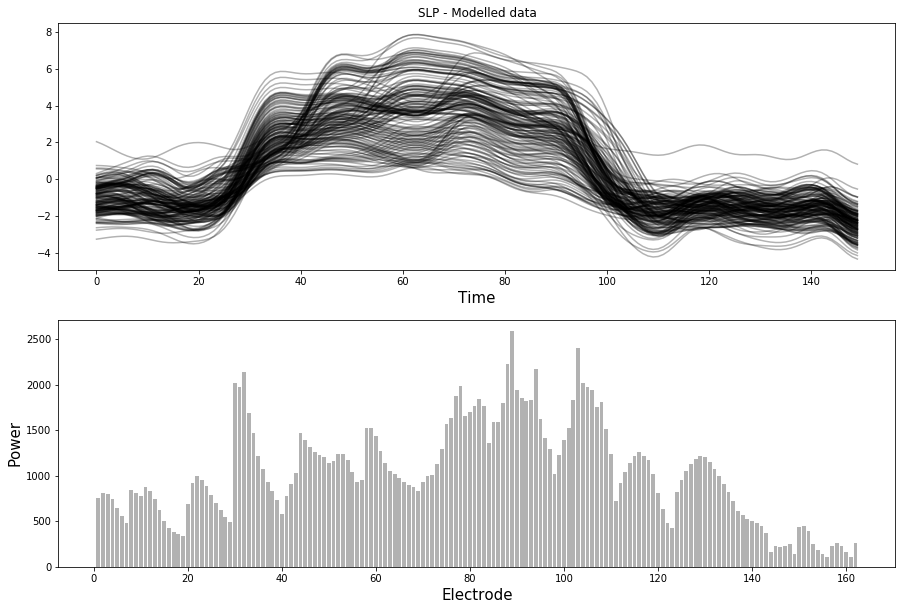

In [3]:
plt.figure(figsize=(15,10))
plt.subplot(211)
plt.plot(slp_ds, color='black', alpha=0.3);
plt.xlabel('Time', fontsize=15)
plt.title('SLP - Modelled data')
plt.subplot(212)
plt.bar(np.arange(1,gain_mat.shape[0]+1), snsr_pwr, color='black', alpha=0.3)
plt.xlabel('Electrode', fontsize=15)
plt.ylabel('Power', fontsize=15)
plt.savefig(f'{results_dir}/figures/fitting_data.png')

In [5]:
nn = SC.shape[0]
ns = gain_mat.shape[0]
nt = slp_ds.shape[0]
I1 = 3.1
time_step = 0.1
x_init = -2.0*np.ones(nn)
z_init = 3.5*np.ones(nn)
# epsilon_slp = 0.1
# epsilon_snsr_pwr = 5
# alpha = 10


# plt.figure(figsize=(20,10))
# plt.subplot(211)
# plt.bar(np.r_[1:ns+1], epsilon_slp)
# plt.xticks(np.r_[1:ns+1:4], np.r_[1:ns+1:4])
# plt.xlabel("Sensor", fontsize=15)
# plt.ylabel(r"$\epsilon_{slp}$", fontsize=20)
# plt.subplot(212)
# plt.bar(np.r_[1:ns+1], epsilon_snsr_pwr)
# plt.xticks(np.r_[1:ns+1:4], np.r_[1:ns+1:4])
# plt.xlabel("Sensor", fontsize=15)
# plt.ylabel(r"$\epsilon_{snsr\_pwr}$", fontsize=20)


stan_fname = 'exp10.50.3'
# lib.utils.stan.compile('/home/anirudh/Softwares/cmdstan-2.18.0', 'vep-snsrfit-ode')

x0_star = np.zeros(nn)
# x_init_star = np.zeros(nn)
# z_init_star = np.zeros(nn)
amplitude_star = 0.0
offset = 0.0
K_star = 0.0
tau0_star = 0.0
epsilon_slp_star = 0.0
epsilon_snsr_pwr_star = 0.0
alpha = 1


param_init = {'x0_star':x0_star, 'amplitude_star':amplitude_star, 'offset':offset,
              'K_star':K_star, 'tau0_star':tau0_star}
#               'epsilon_slp_star':0.0, 'epsilon_snsr_pwr_star':0.0, 'alpha':alpha}
param_init_file = 'param_init.R'
os.makedirs(f'{results_dir}/Rfiles',exist_ok=True)
lib.io.stan.rdump(f'{results_dir}/Rfiles/param_init.R',param_init)


fname_suffix = f'advi_hyper_infer'

data = {'nn':nn, 'ns':ns, 'nt':nt, 'I1':I1, 'time_step':time_step,
        'SC':SC, 'gain': gain_mat, 'x_init':x_init, 'z_init':z_init,
        'slp':slp_ds, 'snsr_pwr':snsr_pwr}
#         'epsilon_slp':epsilon_slp, 'epsilon_snsr_pwr':epsilon_snsr_pwr}
input_Rfile = f'fit_data_snsrfit_ode_{fname_suffix}.R'
os.makedirs(f'{results_dir}/Rfiles',exist_ok=True)
lib.io.stan.rdump(f'{results_dir}/Rfiles/{input_Rfile}',data)

In [6]:
%%bash -s "$stan_fname"
stancompile.sh $1

/home/anirudh/Academia/projects/vep.stan

--- Translating Stan model to C++ code ---
bin/stanc  /home/anirudh/Academia/projects/vep.stan/exp10.50.3.stan --o=/home/anirudh/Academia/projects/vep.stan/exp10.50.3.hpp
Model name=exp10_50_3_model
Input file=/home/anirudh/Academia/projects/vep.stan/exp10.50.3.stan
Output file=/home/anirudh/Academia/projects/vep.stan/exp10.50.3.hpp

--- Linking C++ model ---
g++ -Wall -I . -isystem stan/lib/stan_math/lib/eigen_3.3.3 -isystem stan/lib/stan_math/lib/boost_1.66.0 -isystem stan/lib/stan_math/lib/sundials_3.1.0/include -std=c++1y -DBOOST_RESULT_OF_USE_TR1 -DBOOST_NO_DECLTYPE -DBOOST_DISABLE_ASSERTS -DBOOST_PHOENIX_NO_VARIADIC_EXPRESSION -Wno-unused-function -Wno-uninitialized -I src -isystem stan/src -isystem stan/lib/stan_math/ -DFUSION_MAX_VECTOR_SIZE=12 -Wno-unused-local-typedefs -DEIGEN_NO_DEBUG -DNO_FPRINTF_OUTPUT -pipe   src/cmdstan/main.cpp  -O3 -o /home/anirudh/Academia/projects/vep.stan/exp10.50.3 -include /home/anirudh/Academia/projects/v

DIAGNOSTIC(S) FROM PARSER:



In [7]:
%%bash -s "$stan_fname" "$results_dir" "$input_Rfile" "$fname_suffix"

STAN_FNAME=$1
RESULTS_DIR=$2
INPUT_RFILE=$3
FNAME_SUFFIX=$4
for i in {1..4};
do
./${STAN_FNAME}  id=$((100*${i})) variational \
algorithm=meanfield iter=10000 tol_rel_obj=0.001 elbo_samples=100 \
output_samples=1000 data file=${RESULTS_DIR}/Rfiles/${INPUT_RFILE} \
init=${RESULTS_DIR}/Rfiles/param_init.R random seed=$((987*${i})) \
output file=${RESULTS_DIR}/samples_${FNAME_SUFFIX}_chain${i}.csv \
&> ${RESULTS_DIR}/logs/snsrfit_ode_${FNAME_SUFFIX}_chain${i}.log &
done



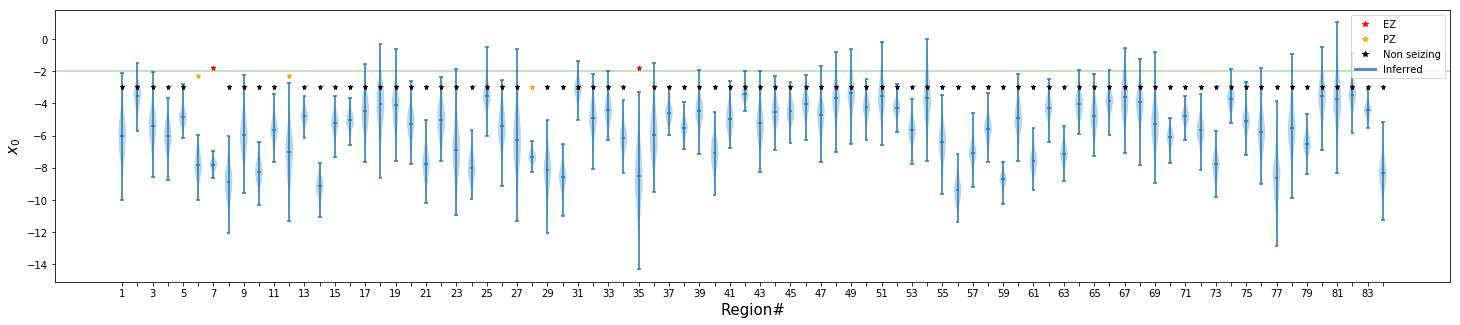

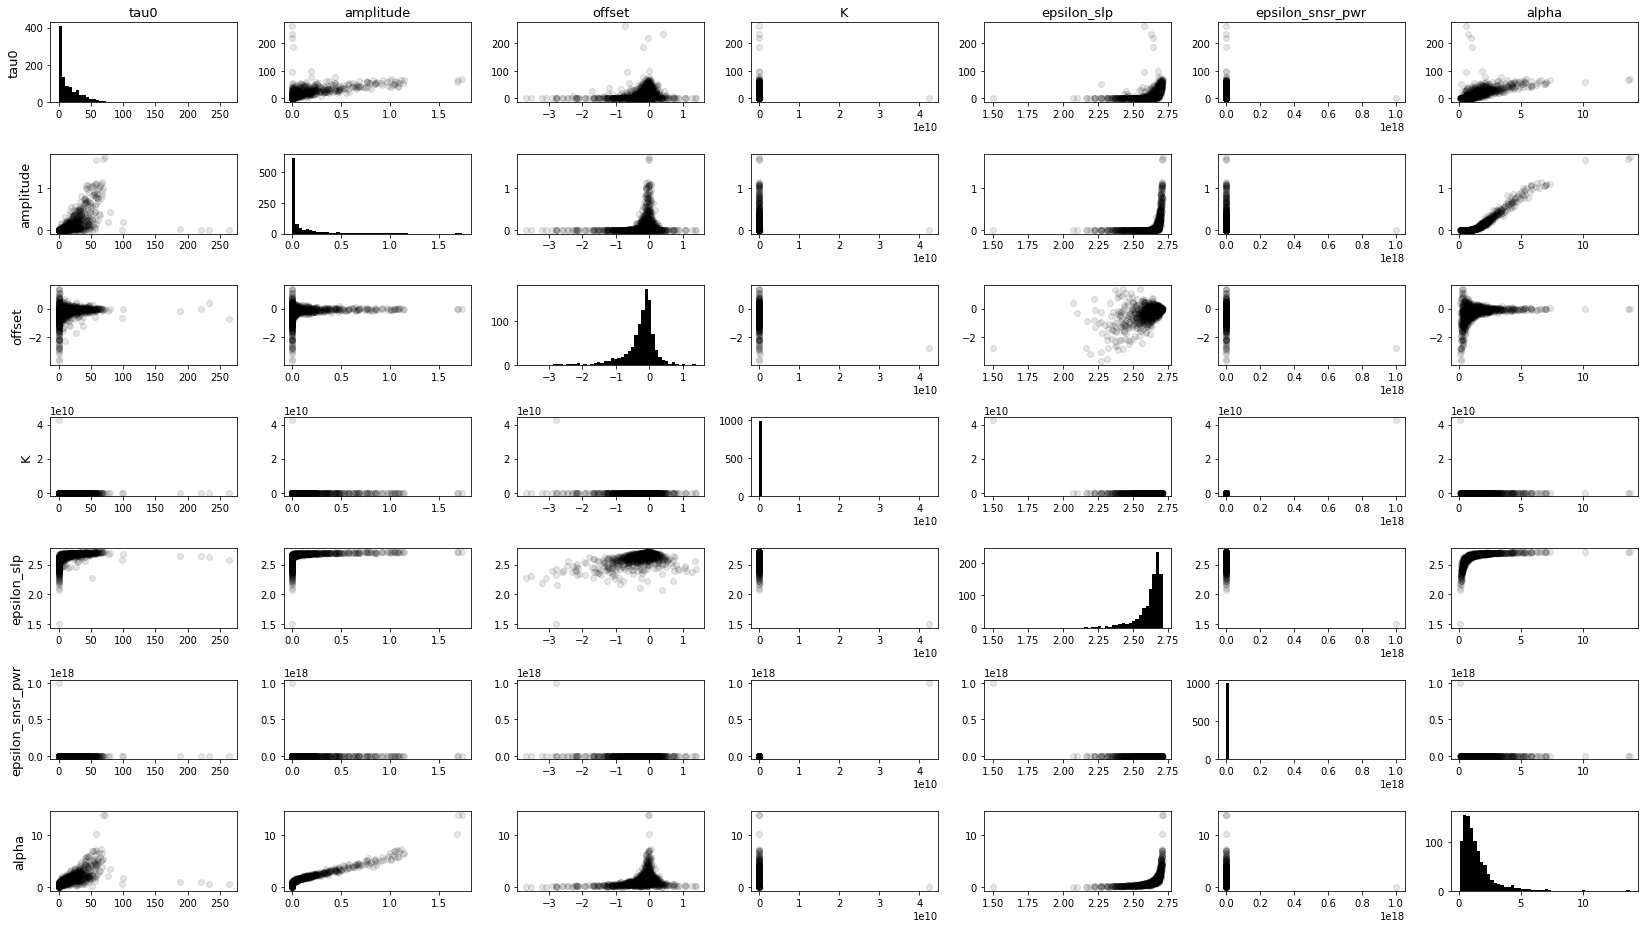

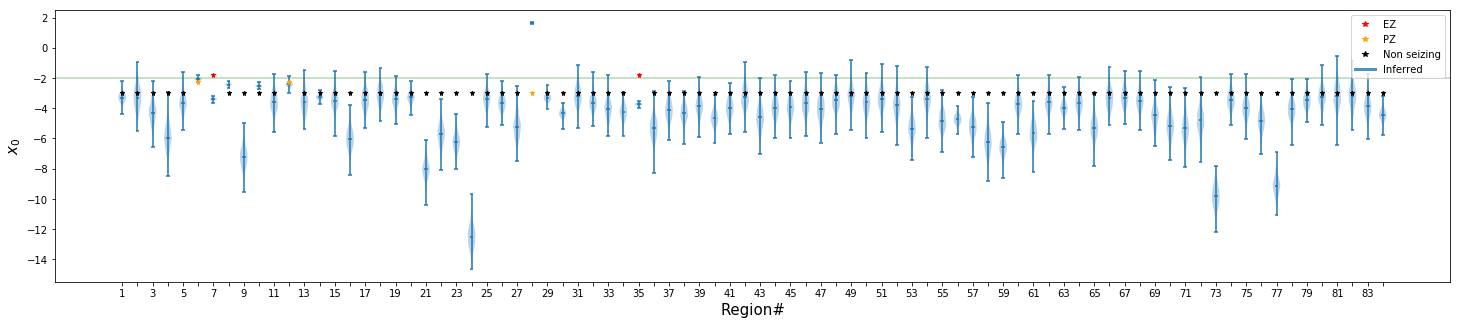

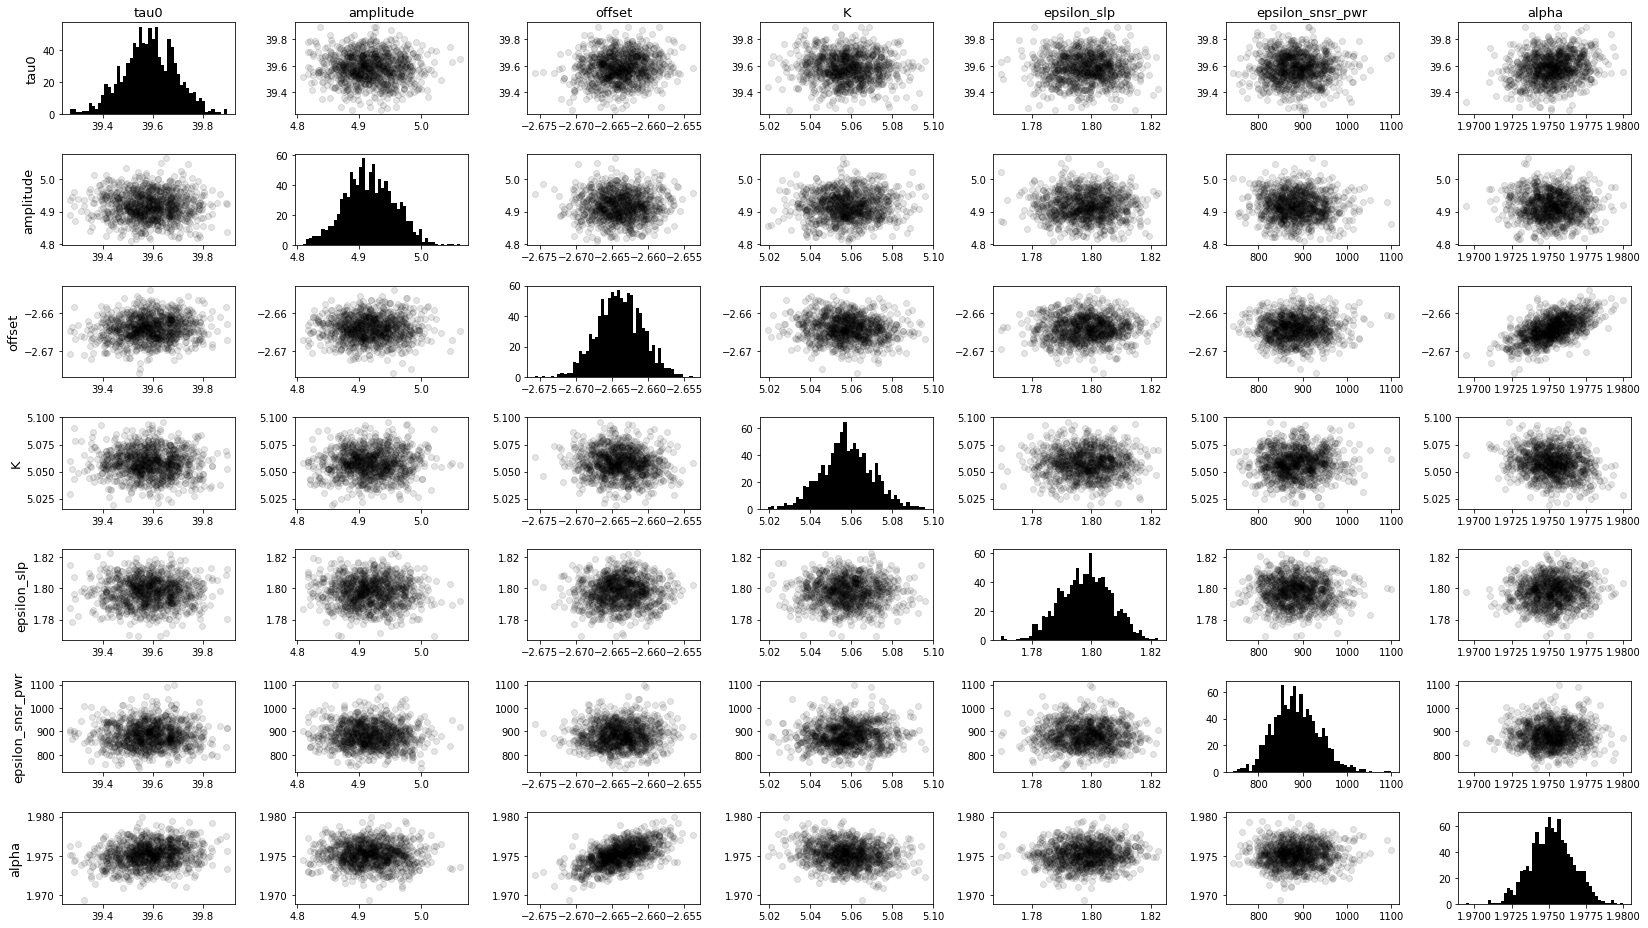

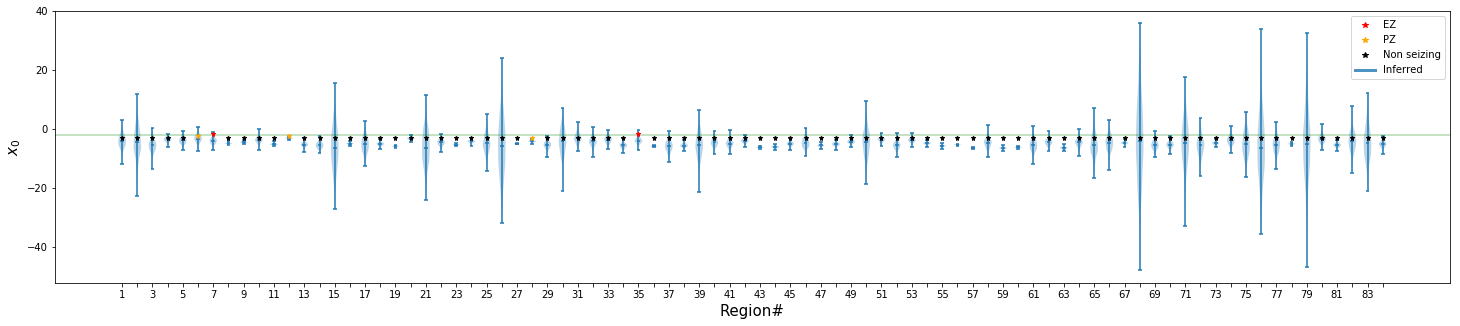

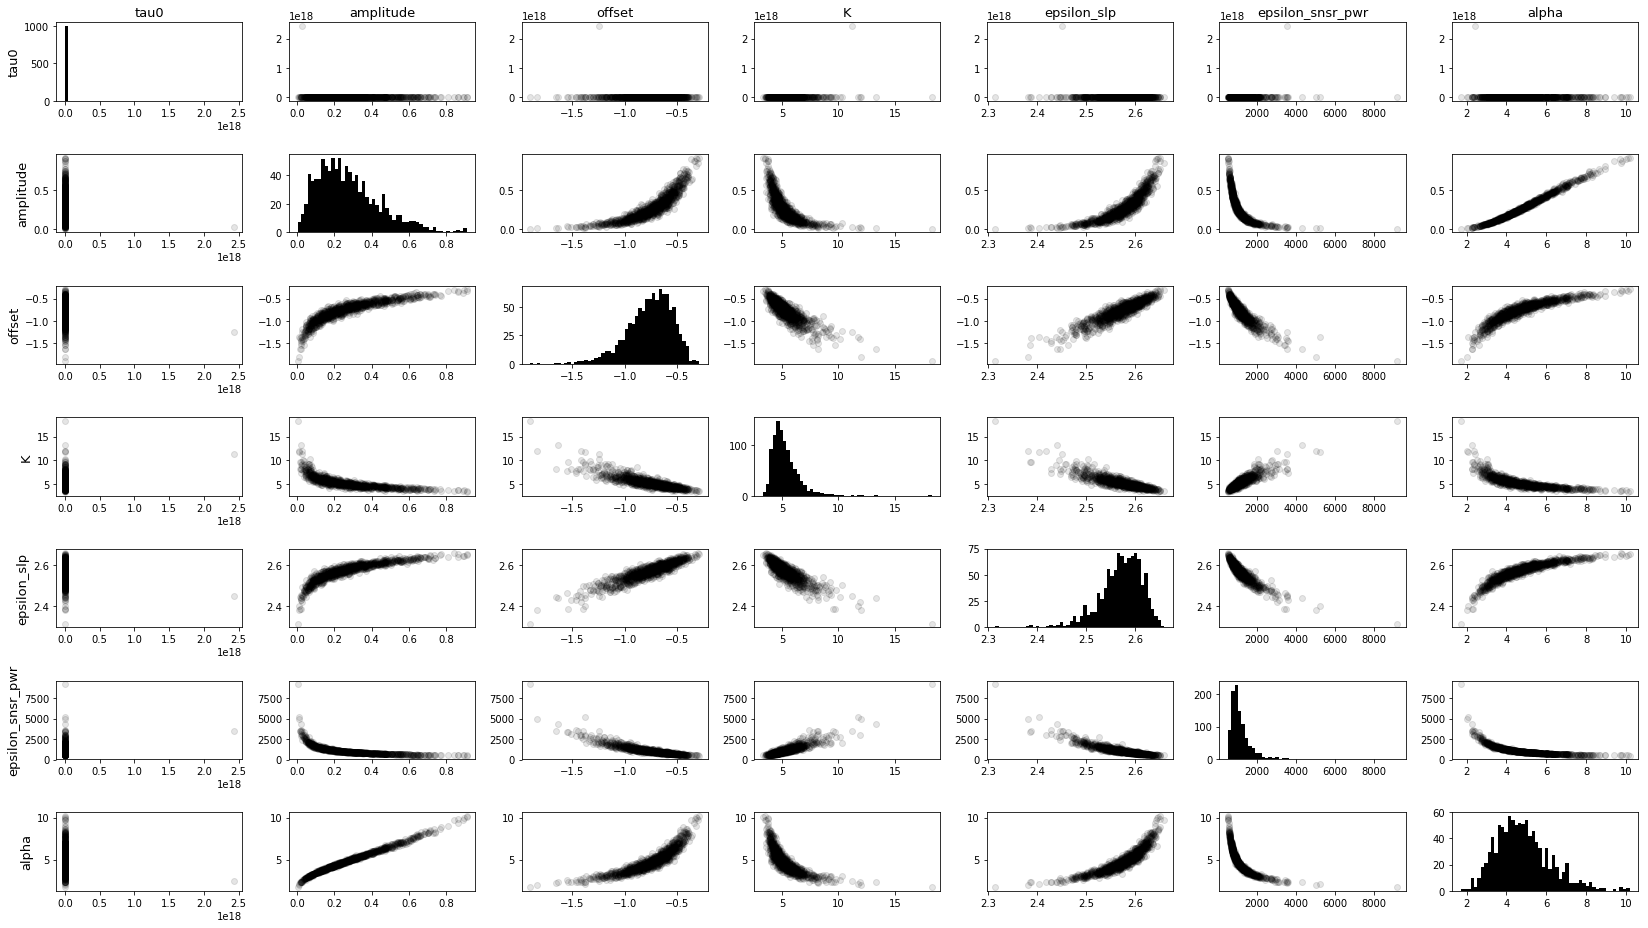

In [8]:
# importlib.reload(lib.plots.stan)
syn_data = np.load('datasets/id002_cj/CJ_syn_tvb_ez=6-34_pz=27-5-11.npz')
fit_data = lib.io.stan.rload(f'{results_dir}/Rfiles/fit_data_snsrfit_ode_{fname_suffix}.R')
x0_true = syn_data['x0']
ez = syn_data['ez']
pz= np.concatenate((syn_data['pz_x0'], syn_data['pz_kplng']))

variables_of_interest = ['x0', 'amplitude', 'offset', 'tau0', 'K', 'epsilon_slp', 'epsilon_snsr_pwr', 'alpha']
chains = [1,3,4]
params = ['tau0', 'amplitude', 'offset', 'K', 'epsilon_slp', 'epsilon_snsr_pwr', 'alpha']
for chain_no in chains:
    pstr_samples = lib.io.stan.read_samples([f'{results_dir}/samples_{fname_suffix}_chain{chain_no}.csv'],
                                            variables_of_interest=variables_of_interest)
#     for key in pstr_samples.keys():
#         pstr_samples[key] = pstr_samples[key][50:]

    lib.plots.stan.x0_violin_syn(pstr_samples['x0'], x0_true, ez, pz, figsize=(25,5), figname=f'{results_dir}/figures/x0_violin_{fname_suffix}_chain{chain_no}.png')
    lib.plots.stan.pair_plots(samples=pstr_samples, params=params, figname=f'{results_dir}/figures/params_pair_plots_{fname_suffix}_chain{chain_no}.png')
#     x_pp_mean = np.mean(pstr_samples['x'], axis=0)
#     z_pp_mean = np.mean(pstr_samples['z'], axis=0)
#     lib.plots.stan.plot_source(x_pp_mean, z_pp_mean, ez, pz, f'{results_dir}/figures/posterior_predicted_src_{fname_suffix}_chain{chain_no}.png')

#     slp = pstr_samples['mu_slp'].mean(axis=0)
#     snsr_pwr = pstr_samples['mu_snsr_pwr'].mean(axis=0)
#     lib.plots.stan.plot_fit_target(data_pred={'slp':slp,'snsr_pwr':snsr_pwr}, data_true={'slp':fit_data['slp'],'snsr_pwr':fit_data['snsr_pwr']},
#                                figname=f'{results_dir}/figures/posterior_predicted_slp_{fname_suffix}_chain{chain_no}.png')


In [ ]:
pstr_samples = lib.io.stan.read_samples([f'{results_dir}/samples_{fname_suffix}_chain{i}.csv' for i in chains],
                                      variables_of_interest=variables_of_interest, nwarmup=nwarmup, nsampling=nsampling)

lib.plots.stan.x0_violin_syn(pstr_samples['x0'], x0_true, ez, pz, figsize=(25,5), figname=f'{results_dir}/figures/x0_violin_{fname_suffix}.png')
lib.plots.stan.nuts_diagnostics(pstr_samples, figsize=(15,10), figname=f'{results_dir}/figures/nuts_diagnostics_{fname_suffix}.png')
lib.plots.stan.pair_plots(pstr_samples, params)

x_pp_mean = np.mean(pstr_samples['x'], axis=0)
z_pp_mean = np.mean(pstr_samples['z'], axis=0)
lib.plots.stan.plot_source(x_pp_mean, z_pp_mean, ez, pz, f'{results_dir}/figures/posterior_predicted_src_{fname_suffix}.png')

slp = pstr_samples['mu_slp'].mean(axis=0)
snsr_pwr = pstr_samples['mu_snsr_pwr'].mean(axis=0)
lib.plots.stan.plot_fit_target(data_pred={'slp':slp,'snsr_pwr':snsr_pwr}, data_true={'slp':fit_data['slp'],'snsr_pwr':fit_data['snsr_pwr']},
                               figname=f'{results_dir}/figures/posterior_predicted_slp_{fname_suffix}.png')

